# Movie Recommendation System

## Content-based filtering
Data: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata

In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Upload the data file

In [2]:
# download the data from link above, you only need to run this cell and upload the file once, unless you reconnect or restart the notebook
from google.colab import files
uploaded = files.upload()

Saving tmdb_5000_movies.csv to tmdb_5000_movies.csv


Load and preprocess data

In [3]:
def load_data():
    # Load the TMDB 5000 movies dataset
    df = pd.read_csv('tmdb_5000_movies.csv')

    # Parse the 'genres' and 'keywords' columns which are in stringified list of dicts
    def parse_features(x):
        try:
            return [i['name'] for i in ast.literal_eval(x)]
        except:
            return []

    df['genres'] = df['genres'].apply(parse_features)
    df['keywords'] = df['keywords'].apply(parse_features)

    # Fill NaN in 'overview' with empty string
    df['overview'] = df['overview'].fillna('')

    # Combine relevant features into a single string (metadata soup)
    def create_soup(row):
        return ' '.join(row['genres']) + ' ' + ' '.join(row['keywords']) + ' ' + row['overview']

    df['soup'] = df.apply(create_soup, axis=1)

    return df

Compute TF-IDF matrix

In [4]:
def compute_tfidf_matrix(df):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['soup'])
    return tfidf_matrix

Compute Cosine Similarity matrix

In [5]:
def compute_similarity_matrix(tfidf_matrix):
    return cosine_similarity(tfidf_matrix, tfidf_matrix)

Input the movie name and get recommendations

In [6]:
def get_recommendations(title, df, similarity_matrix, top_n=10, include_input=True):
    df['title_lower'] = df['title'].str.lower()
    title = title.lower()

    if title not in df['title_lower'].values:
        print(f"Movie '{title}' not found in the dataset.")
        return []

    idx = df[df['title_lower'] == title].index[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # whether to include the movie you input or not when showing the recommendation, you can adjust the value of include_input variable on function parameter
    if include_input:
        sim_scores = sim_scores[:top_n]
    else:
        sim_scores = sim_scores[1:top_n+1]

    recommended_titles = [df.iloc[i[0]]['title'] for i in sim_scores]
    return recommended_titles

def main():
    df = load_data()
    tfidf_matrix = compute_tfidf_matrix(df)
    similarity_matrix = compute_similarity_matrix(tfidf_matrix)

    movie_title = input("Enter a movie title: ")
    recommendations = get_recommendations(movie_title, df, similarity_matrix)

    if recommendations:
        print(f"\nTop recommendations for '{movie_title}':")
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")

if __name__ == "__main__":
    main()

Enter a movie title: Tangled

Top recommendations for 'Tangled':
1. Tangled
2. Into the Woods
3. Out of Inferno
4. Enchanted
5. Ella Enchanted
6. Shrek 2
7. The NeverEnding Story
8. Happily N'Ever After
9. The Horse Whisperer
10. In the Name of the King: A Dungeon Siege Tale


## Collaborative filtering
Data: https://grouplens.org/datasets/movielens/latest/

In [7]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

Load the data

In [8]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

978202/978202 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting all the files now...
Done!


Perform preprocessing to encode users and movies as integer indices

In [9]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


Prepare training and validation data

In [10]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

Create the model

In [12]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

Train the model based on the data split

In [13]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.6589 - val_loss: 0.6202
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.6161 - val_loss: 0.6184
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.6088 - val_loss: 0.6147
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.6071 - val_loss: 0.6135
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.6078 - val_loss: 0.6124


Plot training and validation loss

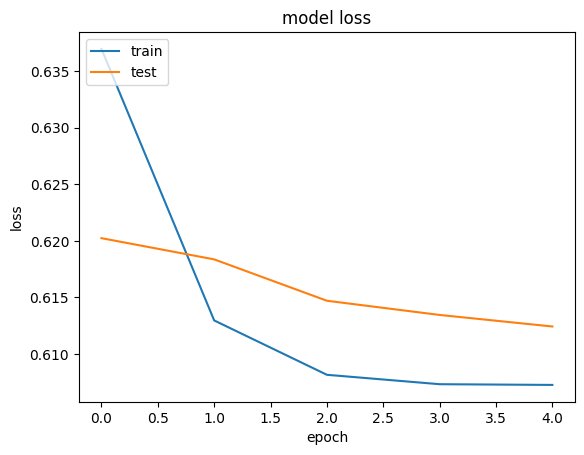

In [14]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Show top 10 movie recommendations to a user

In [15]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Get a user and see the top recommendations
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Showing recommendations for user: 58
Movies with high ratings from user
--------------------------------
Twelve Monkeys (a.k.a. 12 Monkeys) (1995) : Mystery|Sci-Fi|Thriller
Muriel's Wedding (1994) : Comedy
Schindler's List (1993) : Drama|War
Searching for Bobby Fischer (1993) : Drama
Truth About Cats & Dogs, The (1996) : Comedy|Romance
--------------------------------
Top 10 movie recommendations
--------------------------------
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Godfather, The (1972) : Crime|Drama
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action|Adventure
Lawrence of Arabia (1962) : Adventure|Drama|War
Apocalypse Now (1979) : Action|Drama|War
Goodfellas (1990) : Crime|Drama
Godfather: Part II, The (1974) : Crime|Drama
Boondock 